In [1]:
#IMPORTS
#Install+Import Packages
!pip install mechanize
import random
import re
import mechanize
import numpy as np
from random import *
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import filterfalse
from matplotlib.pyplot import figure
import scipy.stats as stats
import pylab
from itertools import permutations

In [2]:
#Upload Data and Define Parameters
#The gly_aa is the fastq data from the capture reaction
gly_aa = open('/YOURDIRECTORY/YOURFILE.fastq').readlines()

#The ctrl is the fastq data of the starting library
ctrl = open('/YOURDIRECTORY/YOURFILE.fastq').readlines()


In [3]:
#Upload Data and Define Parameters
file_type = '.fastq'

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9

#Define the sequence motifs and their start sites: this includes any homemade barcodes.
#In this instance, the example is showing the 7-nt randomized overhang dataset. 
#Position motif1 start: use these start sites to filter for the length of the randomized region of interest.
motif_start = 1
#Motif1 define: 'ACAA' is the homemade barcode for the 7-nt overhang, 'GGACC' is the fixed stem portion.
motif = 'ACAAGGACC'
#Position motif2 starts at: this number should be changed as the overhang length gets changed.
motif2_start = 17
#Motif2 define: this motif is the RT primer binding site and is used for length filtering as well as for quality control purposes. 
motif2 = 'AGATCGGAAGAGCACACGTCT'
#ctrl motif 2 starts at: this is the same motif as the one above, except in certain cases it is different depending on the dataset used. 
ctrlmotif2_start = 17
#ctrlmotif2 define
ctrlmotif2 = 'AGATCGGAAGAGCACACGTCT'

In [4]:
#functions for the initial processing of sequences

def preprocess_seqs(list_of_seqs):

    if file_type == '.fastq':
        seqs = list_of_seqs[1::4]
        qualities = list_of_seqs[3::4]
        print('Total seqs: '+str(len(seqs)))

        #Filter by quality
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        for seq in range(len(qualities)):
            overlap=0
            for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
                overlap+=qualities[seq].count(char)
            if overlap/len(qualities[1])>quality_cutoff:
                high_quality.append(seqs[seq].strip("\n"))
        print('High quality seqs: '+str(len(high_quality)))
        
    #Take reverse complement if desired
    pre_trim = []
    if rc == 'yes':
        rc_seqs = []
        for sequence in high_quality:
            rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n')) #reverse_complement is imported from one of the packages above
        pre_trim = rc_seqs
    else:
        for sequence in high_quality:
            pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
        print('Reverse Comp = '+str(rc)) 

    #Trim to keep only seqs that are of the correct length and contain the encoded constant stem regions. 
    trimmed = []
    for seq in pre_trim:
        if motif in seq:
            if motif2 in seq:
                trimmed.append(seq[(motif_start-1)+len(motif):(motif2_start-1)]) #the -1 accounts for indexing starting at 0 in python. dont mess with this
    print('Seqs after trimming: '+str(len(trimmed))) 
    
    #All processed seqs
    processed_seqs = trimmed
    #Unique seqs
    processed_seqs_unique = list(set(trimmed))
    
    return processed_seqs, processed_seqs_unique


def preprocess_ctrl_seqs(list_of_seqs):
        
    if file_type == '.fastq':
        seqs = list_of_seqs[1::4]
        qualities = list_of_seqs[3::4]
        print('Ctrl Total seqs: '+str(len(seqs)))

        #Filter by quality
        high_quality = []
        acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
        for seq in range(len(qualities)):
            overlap=0
            for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
                overlap+=qualities[seq].count(char)
            if overlap/len(qualities[1])>quality_cutoff:
                high_quality.append(seqs[seq].strip("\n"))
        print('Ctrl High quality seqs: '+str(len(high_quality)))
        
    #Take RC if desired
    pre_trim = []
    if rc == 'yes':
        rc_seqs = []
        for sequence in high_quality:
            rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n')) #reverse_complement is imported from one of the packages above
        pre_trim = rc_seqs
    else:
        for sequence in high_quality:
            pre_trim.append(str(Seq(sequence)).strip('\n'))
    if rc == 'yes':
        print('Reverse Comp = '+str(rc)) 

    #Trim to keep only seqs that are of the correct length and contain the encoded constant stem regions.
    trimmed = []
    for seq in pre_trim:
        if motif in seq:
            if ctrlmotif2 in seq:
                trimmed.append(seq[(motif_start-1)+len(motif):(motif2_start-1)]) #the -1 accounts for indexing starting at 0 in python. dont mess with this
    print('Ctrl Seqs after trimming: '+str(len(trimmed))) 
    
    #All processed seqs
    processed_ctrl_seqs = trimmed
    #Unique seqs
    processed_ctrl_seqs_unique = list(set(trimmed))
    
    return processed_ctrl_seqs, processed_ctrl_seqs_unique



In [8]:
#Obtain the sequence parameters
gly_processed_seqs, gly_processed_seqs_unique = preprocess_seqs(gly_aa)
#The number in the paranthesis will vary depending on the randomized region length. Ex. 4^7 = 16384
gly_top_seqs = Counter(gly_processed_seqs).most_common(16384)
print('Unique AA seqs '+str(len(gly_processed_seqs_unique)))
print(gly_top_seqs[:10])
import pandas as pd
df = pd.DataFrame(gly_top_seqs, columns =['Sequence', 'Counts'])
df.to_excel(r'/YOURDIRECTORY/YOURFILE.xlsx', index = False)

Total seqs: 1561120
High quality seqs: 1426381
Seqs after trimming: 314484
Unique AA seqs 15765
[('AGATCGG', 8821), ('TGTAAAA', 613), ('TGCAAAA', 521), ('TAGATCG', 516), ('TGTGAAA', 512), ('TGGAAAA', 483), ('TGGGAAA', 467), ('CAGATCG', 429), ('TGCGAAA', 411), ('TGAAAAA', 393)]


In [6]:
#Obtain the sequence parameters of the control library
ctrl_processed_ctrl_seqs, ctrl_processed_ctrl_seqs_unique = preprocess_ctrl_seqs(ctrl)
#The number in the paranthesis will vary depending on the randomized region length. Ex. 4^7 = 16384
ctrl_top_seqs = Counter(ctrl_processed_ctrl_seqs).most_common(16384)
print('Unique control seqs '+str(len(ctrl_processed_ctrl_seqs_unique)))
print(ctrl_top_seqs[:10])
import pandas as pd
df = pd.DataFrame(ctrl_top_seqs, columns =['Sequence', 'Counts'])
df.to_excel(r'/YOURDIRECTORY/YOURFILE.xlsx', index = False)

Ctrl Total seqs: 2701385
Ctrl High quality seqs: 2459878
Ctrl Seqs after trimming: 434419
Unique control seqs 16354
[('AGATCGG', 20981), ('GTTCTAC', 1824), ('TCTACAG', 1790), ('ACAGTCC', 1378), ('CTACAGT', 1363), ('TAGATCG', 1089), ('CAGATCG', 812), ('TACAGTC', 787), ('CAGAGTT', 742), ('GAGTTCT', 628)]


In [18]:
#Normalization of sequences that captured glycine
ctrl_top_seqs_dict = dict(ctrl_top_seqs)
#The number 26.6 is obtained by dividing the Ctrl Seqs after trimming number with the Unique control seqs number (434419 / 16354 = 26.6) to obtain the expected number of reads for each sequence if the starting library is truly randomized.
#v > 5 ensures that only sequences with 5 reads or more are included in the analysis. This is to ensure that no spurious seuqences make their way to the top of the read counts list. 
ctrl_top_seqs_dict = {k: v / 26.6 for k, v in ctrl_top_seqs_dict.items() if v > 5}
gly_top_seqs_dict = dict(gly_top_seqs)

normalized_gly_seqs = {key: gly_top_seqs_dict[key] // ctrl_top_seqs_dict.get(key, 0) if ctrl_top_seqs_dict.get(key,0) != 0 else 0
                        for key in gly_top_seqs_dict.keys()}

sorted_normalized_gly_seqs = sorted(normalized_gly_seqs.items(), key=lambda item: item[1])[::-1]
print(sorted_normalized_gly_seqs[:10])

import pandas as pd
df = pd.DataFrame(sorted_normalized_gly_seqs, columns =['Sequence', 'Normalized counts'])
df.to_excel(r'/YOURDIRECTORY/YOURFILE.xlsx', index = False)

[('TGTGAAA', 309.0), ('TGCGAAA', 266.0), ('TGAGAAA', 246.0), ('TTCAAAG', 221.0), ('ATTTTTT', 217.0), ('TTTAACG', 215.0), ('TGTAAAA', 209.0), ('AGTTTAT', 206.0), ('TGCAAAA', 203.0), ('ATTATAT', 201.0)]


<Figure size 432x288 with 0 Axes>

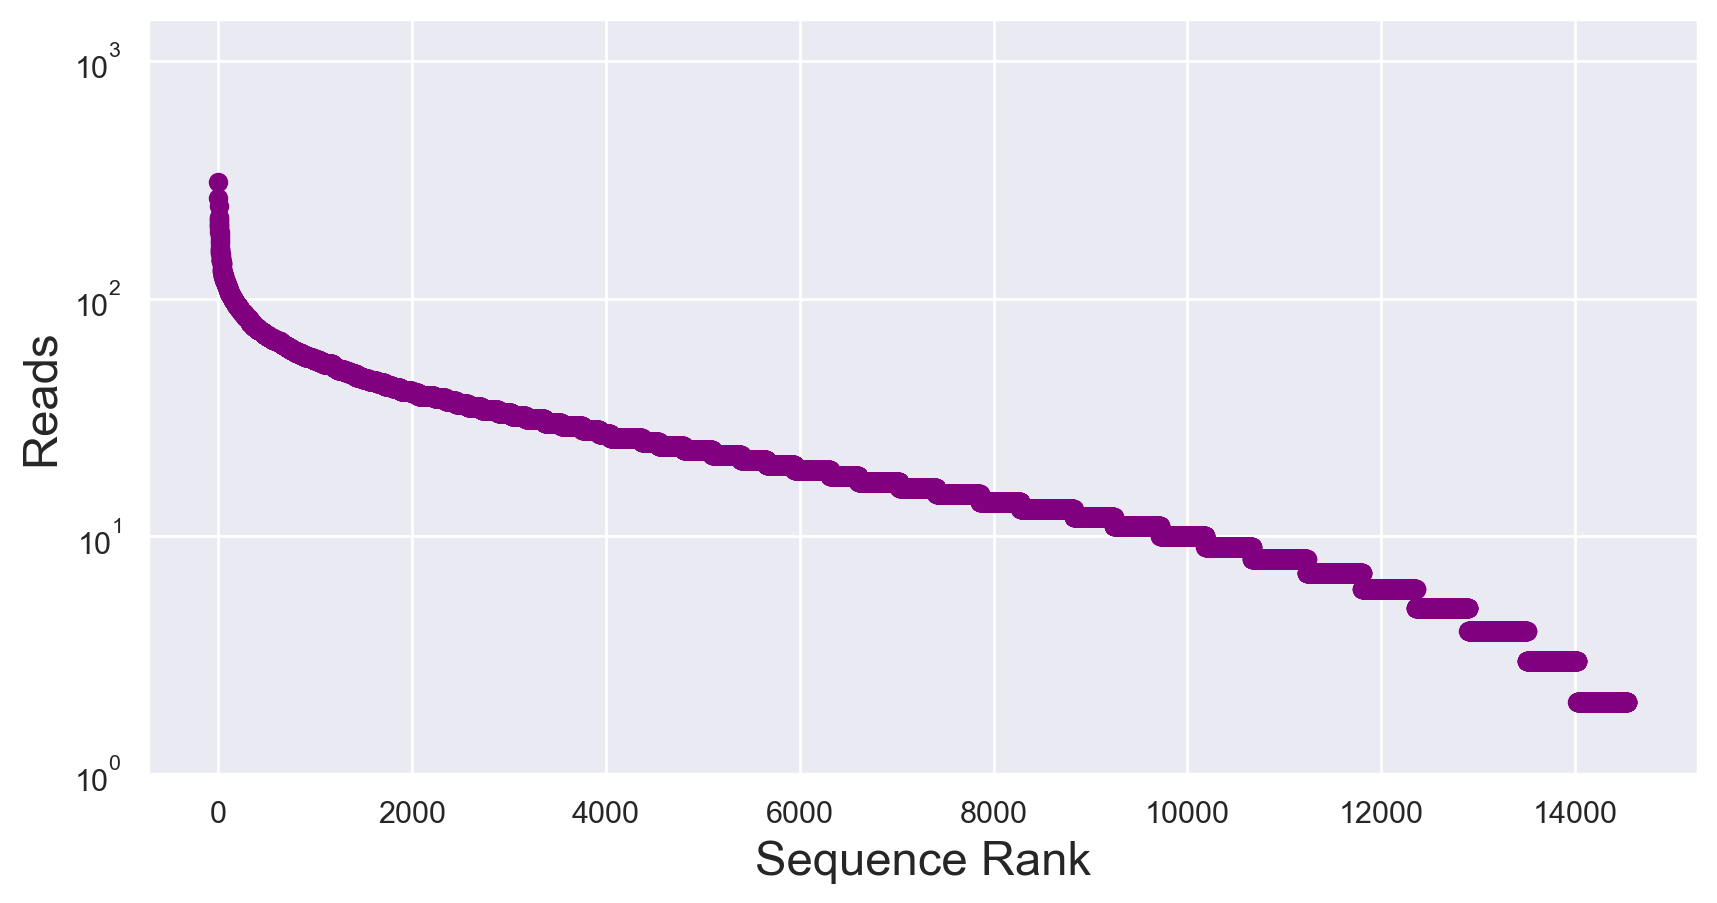

In [20]:
#Sequence read vs. rank plot
plt.figure(facecolor="white")
figure(figsize=(10, 5), dpi=200)
ordered_counts_aa = sorted(dict(Counter(normalized_gly_seqs)).values(), reverse=True)
plt.scatter(range(1,len([i for i in ordered_counts_aa if i > 1])+1), [i for i in ordered_counts_aa if i > 1], color = 'purple', label = 'All AA Sequences')
plt.xlabel('Sequence Rank', fontsize = 17)
plt.ylabel('Reads', fontsize = 17)
plt.yscale('log')
plt.ylim([1, 1500])
plt.savefig(r'/YOURDIRECTORY/YOURFILE.png', bbox_inches='tight')


(1, 100000)

<Figure size 432x288 with 0 Axes>

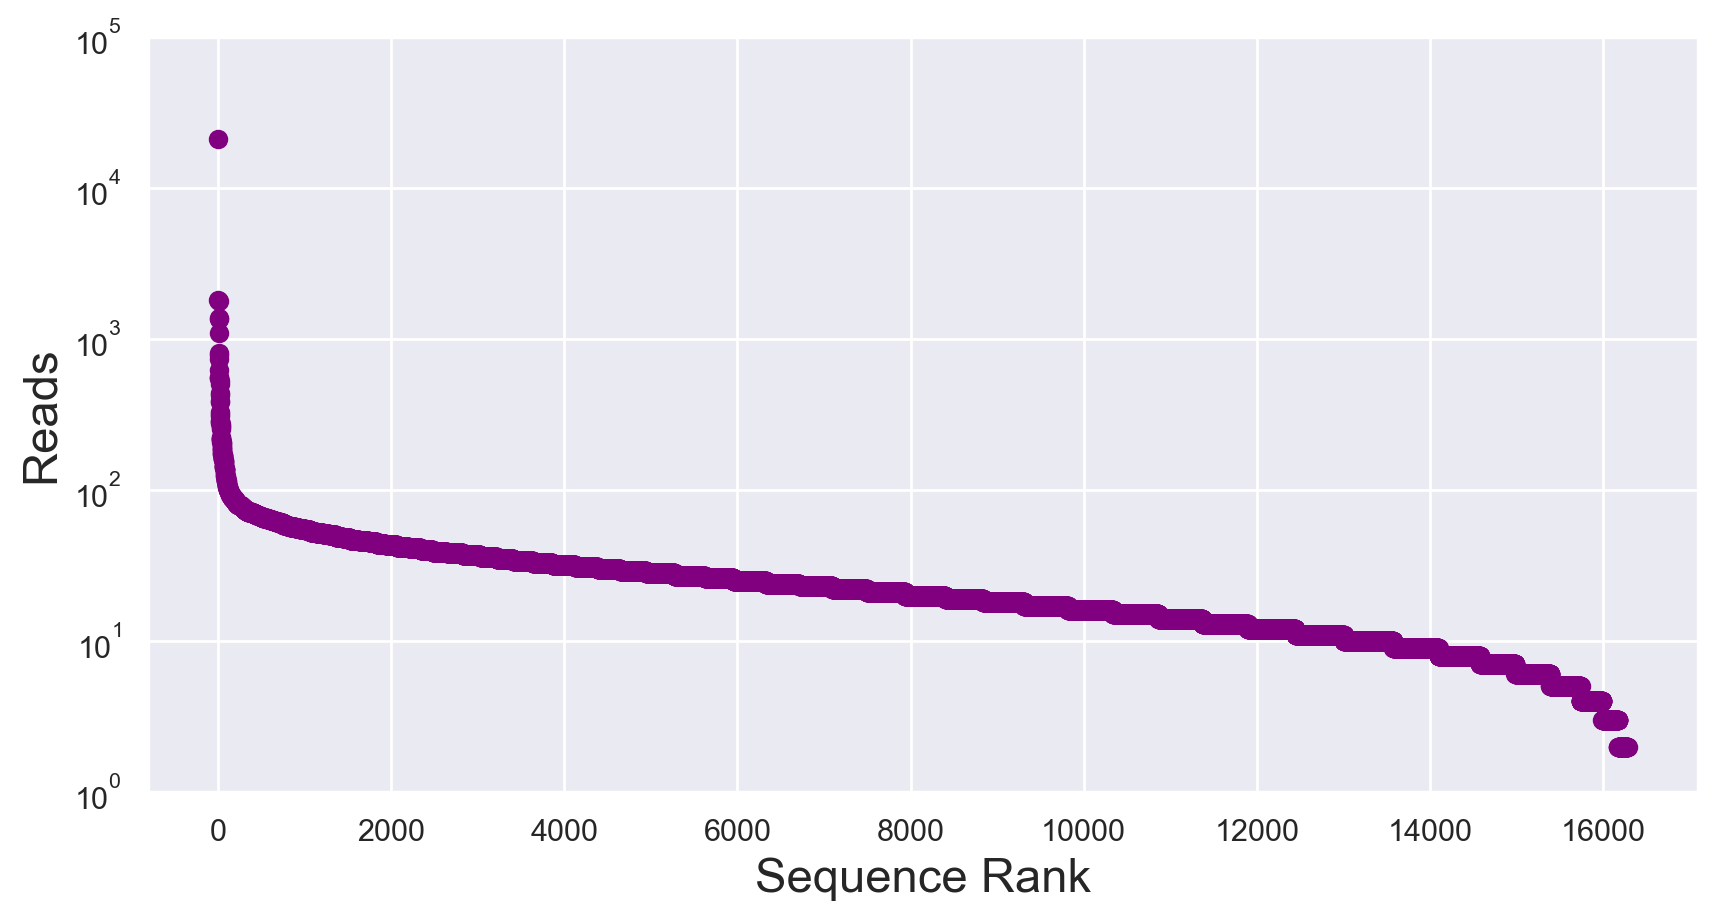

In [12]:
#This plot looks at the composition of the starting library and it shows just how biased the "randomized" library synhtesis is.
plt.figure(facecolor="white")
figure(figsize=(10, 5), dpi=200)
ordered_counts_ctrl = sorted(dict(Counter(ctrl_processed_ctrl_seqs)).values(), reverse=True)
plt.scatter(range(1,len([i for i in ordered_counts_ctrl if i > 1])+1), [i for i in ordered_counts_ctrl if i > 1], color = 'purple', label = 'All AA Sequences')
plt.xlabel('Sequence Rank', fontsize = 17)
plt.ylabel('Reads', fontsize = 17)
plt.yscale('log')
plt.ylim([1, 100000])

[('TCCTTCG', 26.0), ('TTCTCTC', 26.0), ('GAGGTGT', 26.0), ('TCCACGG', 26.0), ('ATCCGCG', 26.0), ('GCCGTGG', 26.0), ('GCCCCTT', 26.0), ('GACCGTT', 26.0), ('AATCTCG', 26.0), ('ATTCGTT', 26.0)]


(1, 100000)

<Figure size 432x288 with 0 Axes>

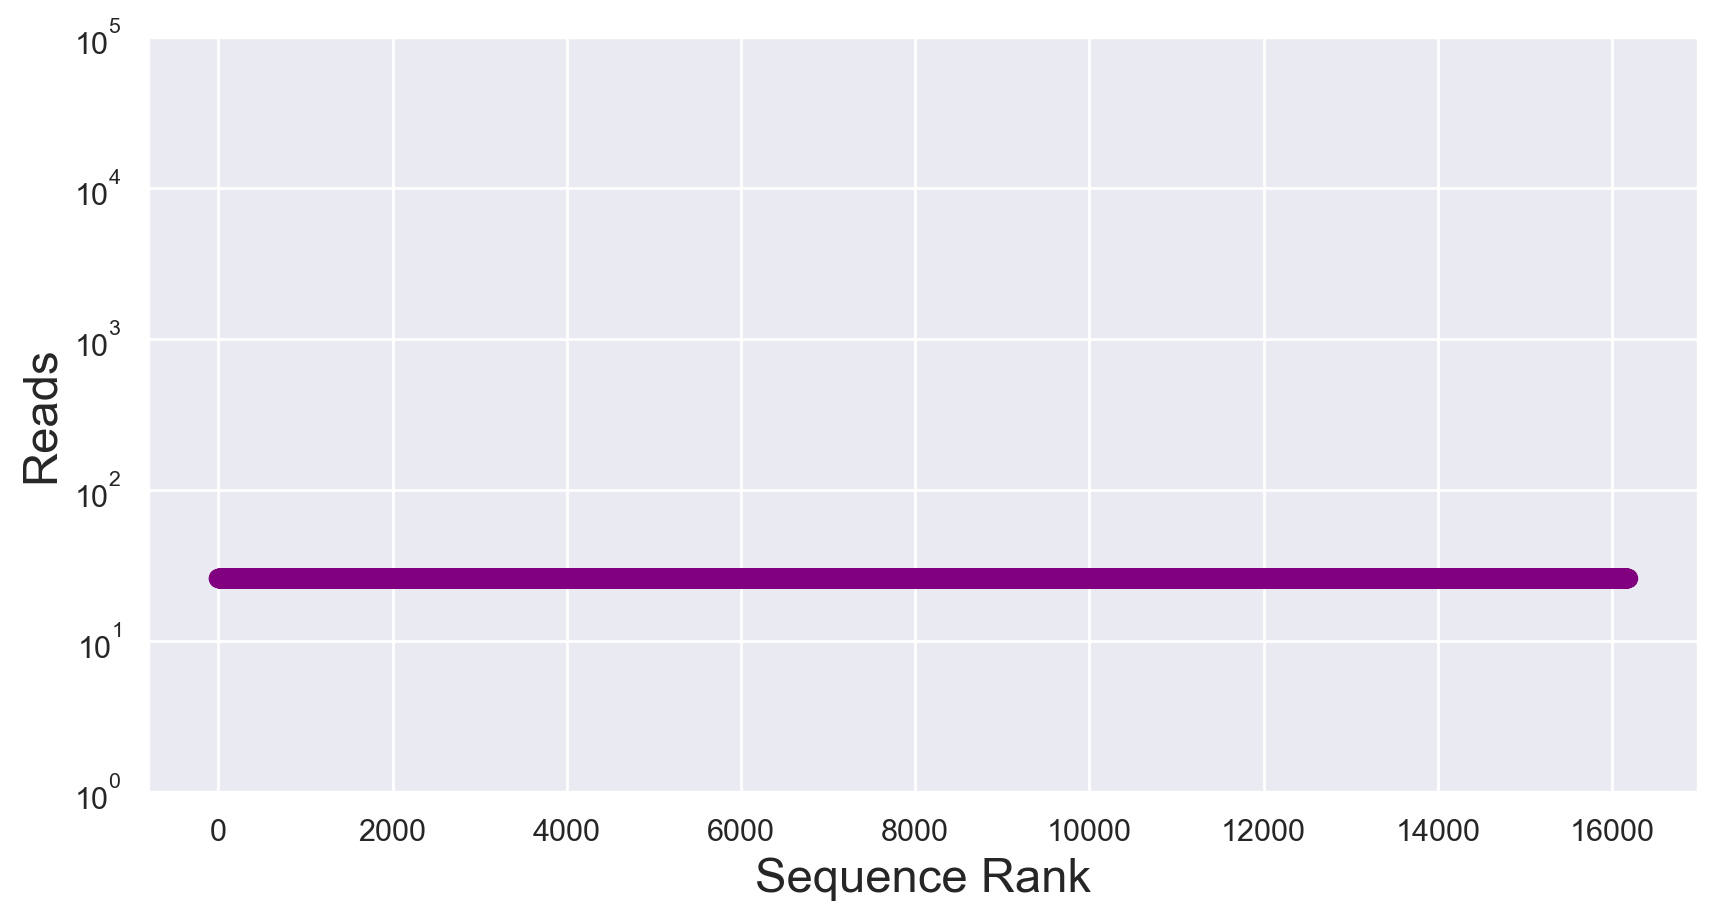

In [14]:
#Normalization of control sequences -- internal sanity check
#This plot shows that if control sequences are normalized using the algorithm above, we end up with a truly random, uniformly distributed sequence space.
ctrl_top_seqs_dict = dict(ctrl_top_seqs)
ctrl_top_seqs_dict2 = {k: v / 26.6 for k, v in ctrl_top_seqs_dict.items() if v > 2}
gly_top_seqs_dict = dict(gly_top_seqs)

normalized_gly_seqs = {key: ctrl_top_seqs_dict[key] // ctrl_top_seqs_dict2.get(key, 0) if ctrl_top_seqs_dict2.get(key,0) != 0 else 0
                        for key in ctrl_top_seqs_dict2.keys()}

sorted_normalized_gly_seqs = sorted(normalized_gly_seqs.items(), key=lambda item: item[1])[::-1]
print(sorted_normalized_gly_seqs[:10])

import pandas as pd
df = pd.DataFrame(sorted_normalized_gly_seqs, columns =['Sequence', 'Normalized counts'])

plt.figure(facecolor="white")
figure(figsize=(10, 5), dpi=200)
ordered_counts_ctrl = sorted(dict(Counter(normalized_gly_seqs)).values(), reverse=True)
plt.scatter(range(1,len([i for i in ordered_counts_ctrl if i > 1])+1), [i for i in ordered_counts_ctrl if i > 1], color = 'purple', label = 'All AA Sequences')
plt.xlabel('Sequence Rank', fontsize = 17)
plt.ylabel('Reads', fontsize = 17)
plt.yscale('log')
plt.ylim([1, 100000])